## Applying machine learning to number theory problem

Sato-tate group classification problem:

Given normalized Frobenius traces, is it possible to 
- determine whether Sato-Tate group  is USp(4)?
- Extended problem: Classifying specific type of Sato-Tate group in the LMF (6 classes)

#### Some applicable machine learning techniques
- Multi-layer perceptron
- Naive Bayes classification

### Package requirements

In [1]:
import numpy as np
import json
from sklearn import preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch
import torch.nn as nn

### Processing data

In [34]:
with open('./g2st.txt') as f:
    data = [l for l in f.readlines()]

In [36]:
data[0]

'1:[17,12,-28,-6,0,4,1]:12128818716:[1.414214,-1.133893,-0.603023,0.277350,-0.485071,0.229416,1.251086,0.742781,-0.538816,-0.164399,-0.457496,0.000000,1.098885,-0.260378,0.512148,0.977356,-0.712069,-2.340823,1.012579,2.634342,-1.059998,0.507673,2.189082,1.773593,1.160084,-0.095783,0.940721,0.266207,0.174741,-0.512615,-0.424094,0.819232,0.651031,-0.079809,-0.861586,-0.619059,0.456172,-0.149487,0.520306,-0.434145,-0.719816,0.427482,1.063322,-0.619586,-0.870544,0.000000,0.462573,0.131024,-0.258738,-1.223898,-0.126239,-2.370375,-1.233253,-1.219422,0.000000,-1.622273,-0.119310,0.059444,0.701047,-0.799022,-0.340229,0.169570,2.134293,0.384755,-0.817102,2.469409,1.231162,-0.212899,-1.477783,-0.104399,-0.673114,-2.003295,-0.919757,-0.405616,-0.250943,1.098628,-0.939490,1.465596,0.926003,-0.578020,1.681993,-0.381819,0.475114,0.283158,0.233890,1.490389,1.068901,-0.370196,1.096588,0.135943,1.083105,0.358129,1.605161,0.088648,-1.752432,-0.087454,1.418781,0.513083,-1.949083,-0.084290]\n'

In [5]:
### preprocessing and Spliting data
def split_data_train_test(data, long_input=True, normalized_data=True, test_size=0.2):
    datapoints = [point.split(':') for point in data]
    labels_data = [int(point[0]) for point in datapoints]
    if long_input:
        input_data = [json.loads(point[3]) for point in datapoints]
    else:
        input_data = [json.loads(point[1]) for point in datapoints]
    input_data_pd = pd.DataFrame(input_data)
    if not long_input:
        input_data_pd[6] = input_data_pd[6].fillna(0)

    if normalized_data:
        input_data_pd = preprocessing.normalize(input_data_pd)
        input_data_pd = pd.DataFrame(input_data_pd, columns=input_data_pd.columns)
    
    X = input_data_pd.to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, labels_data, test_size=0.2)
    return X_train, X_test, y_train, y_test

class PolynomialDataset(Dataset):
    def __init__(self, X, Y):
        self.input_data = X
        self.labels = Y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.input_data[idx], self.labels[idx]

### Creating dataset object

In [6]:
X_train, X_test, y_train, y_test = split_data_train_test(data, normalized_data=False)

In [39]:
y_train[0]

0

In [29]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
train_dataset = PolynomialDataset(X_train, y_train)
test_dataset = PolynomialDataset(X_test, y_test)

batch_size = 50
n_iters = 20000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

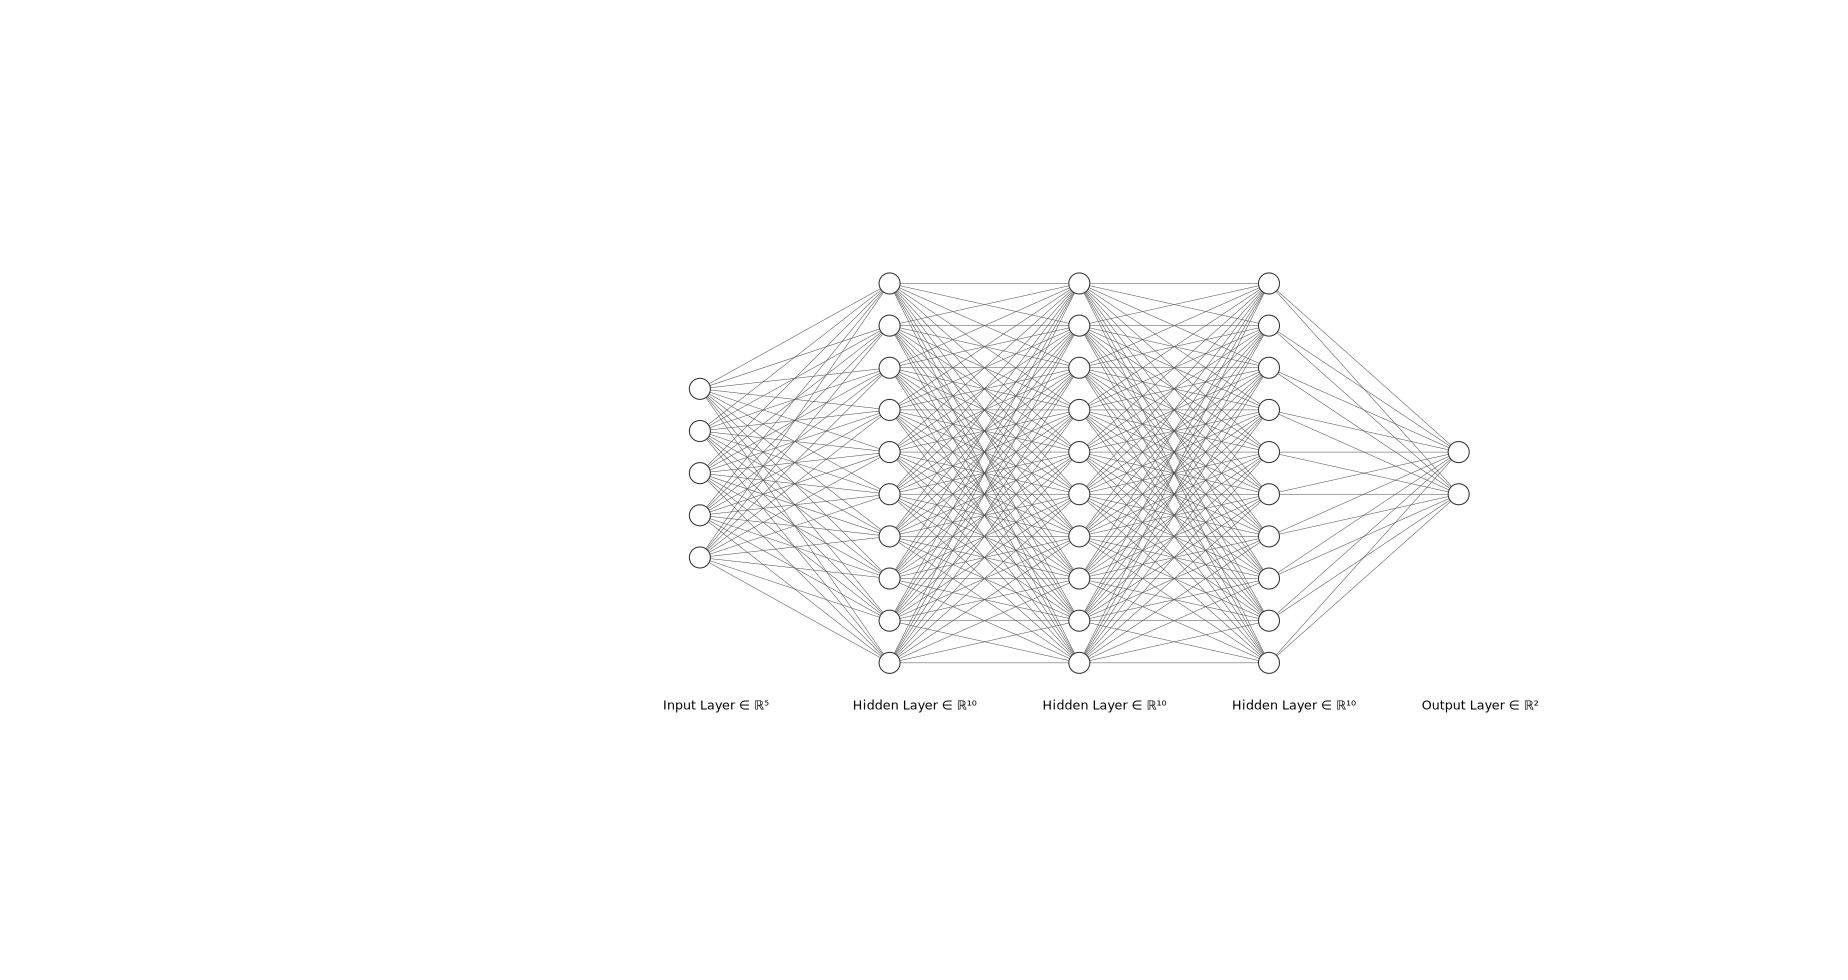

In [44]:
### Definition of network model
# 1 input layer - 100 input unit
# 3 hidden layer (customized size)
# 1 output layer - 2 unit (binary classification)

## below is a visualization of a smaller scaled FFNN
from IPython.core.display import SVG
SVG(filename='nn.svg')

In [30]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
        
        
        # Define batch norm
        #self.batch_norm = nn.BatchNorm1d(hidden_dim)

        # Define proportion or neurons to dropout
        #self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

In [41]:
input_dim = 100
hidden_dim = 200
output_dim = 2

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
criterion = nn.CrossEntropyLoss()

In [42]:
device = torch.device("cpu")#("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [43]:
iter = 0

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = torch.tensor(inputs).requires_grad_()
        inputs = inputs.to(device)
        # Load images with gradient accumulation capabilities
        #images = images.view(-1, 28*28).requires_grad_()
        labels = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(inputs)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for inputs, labels in test_loader:
                inputs = torch.tensor(inputs).requires_grad_()
                inputs = inputs.to(device)
                # Load images with gradient accumulation capabilities
                #images = images.view(-1, 28*28).requires_grad_()
                labels = labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(inputs)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * float(correct) / float(total)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


/scratch2/hle/py3_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/scratch2/hle/py3_env/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 500. Loss: 0.6126779317855835. Accuracy: 69.4125
Iteration: 1000. Loss: 0.48222407698631287. Accuracy: 83.9685
Iteration: 1500. Loss: 0.3443305492401123. Accuracy: 90.429
Iteration: 2000. Loss: 0.3136032223701477. Accuracy: 95.298
Iteration: 2500. Loss: 0.12424015253782272. Accuracy: 96.394
Iteration: 3000. Loss: 0.16351869702339172. Accuracy: 97.0285
Iteration: 3500. Loss: 0.08188510686159134. Accuracy: 97.347
Iteration: 4000. Loss: 0.1211736872792244. Accuracy: 97.5315
Iteration: 4500. Loss: 0.21857866644859314. Accuracy: 97.659
Iteration: 5000. Loss: 0.03125850856304169. Accuracy: 97.776
Iteration: 5500. Loss: 0.036842238157987595. Accuracy: 97.832
Iteration: 6000. Loss: 0.12101670354604721. Accuracy: 97.917
Iteration: 6500. Loss: 0.06471139192581177. Accuracy: 97.9405
Iteration: 7000. Loss: 0.07689313590526581. Accuracy: 97.993
Iteration: 7500. Loss: 0.01925298199057579. Accuracy: 98.012
Iteration: 8000. Loss: 0.06220601126551628. Accuracy: 98.074
Iteration: 8500. Loss: 